In [1]:
! pip install panphon # for conversion_tools
! pip install epitran

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.9/78.9 kB 4.1 MB/s eta 0:00:00
  Created wheel for unicodecsv: filename=unicodecsv-0.14.1-py3-none-any.whl size=10744 sha256=45e6081dfd85182f1e573b9dad8036505a569f1c02c4df755ec30e19b034ffd4
  Stored in directory: /root/.cache/pip/wheels/f2/67/7d/2e80818c2f3dc8f0735d0810338c47e95d3212114ab97b4ede
Successfully built unicodecsv
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 7.4 MB/s eta 0:00:00


In [136]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import json

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm

from models import ResBlock, ASRModel
import fast_conversion as cv

In [3]:
# yor data
import gdown

# feature & data file
file_id = "18gejiyyyx3J1jVGnlOyPeFsgoDXVuoZr"
url = f"https://drive.google.com/uc?id={file_id}"
output = "tensor_file.pt"
gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=18gejiyyyx3J1jVGnlOyPeFsgoDXVuoZr
From (redirected): https://drive.google.com/uc?id=18gejiyyyx3J1jVGnlOyPeFsgoDXVuoZr&confirm=t&uuid=556e3636-44f1-4766-8cad-9cd925772ca5
To: /content/tensor_file.pt
100%|██████████| 285M/285M [00:04<00:00, 68.4MB/s]


'tensor_file.pt'

In [4]:
# TIMIT arpa2idx
file_id = "1s20qxR1bBtx2c5YypYsMNTkSG8oicc_7"
url = f"https://drive.google.com/uc?id={file_id}"
output = "arpa2idx.txt"
gdown.download(url, output, quiet=False)

arpa2idx = dict()
with open('arpa2idx.txt', mode = 'r') as f:
  for line in f:
    arpa2idx[line.split()[0]] = int(line.split()[1])

idx2arpa = dict([idx, arpa] for arpa, idx in arpa2idx.items())

print('\n')
print(arpa2idx)
print(idx2arpa)

Downloading...
From: https://drive.google.com/uc?id=1s20qxR1bBtx2c5YypYsMNTkSG8oicc_7
To: /content/arpa2idx.txt
100%|██████████| 246/246 [00:00<00:00, 1.03MB/s]



{'a': 2, 'aa': 3, 'ae': 4, 'ah': 5, 'ao': 6, 'ax': 7, 'axr': 8, 'b': 9, 'ch': 10, 'd': 11, 'dh': 12, 'e': 13, 'eh': 14, 'er': 15, 'f': 16, 'g': 17, 'h': 18, 'hv': 19, 'ih': 20, 'ix': 21, 'iy': 22, 'jh': 23, 'k': 24, 'l': 25, 'm': 26, 'n': 27, 'ng': 28, 'o': 29, 'oh': 30, 'p': 31, 'q': 32, 'r': 33, 's': 34, 'sh': 35, 't': 36, 'th': 37, 'uh': 38, 'uw': 39, 'ux': 40, 'v': 41, 'w': 42, 'y': 43, 'z': 44, 'zh': 45, '<blank>': 0}
{2: 'a', 3: 'aa', 4: 'ae', 5: 'ah', 6: 'ao', 7: 'ax', 8: 'axr', 9: 'b', 10: 'ch', 11: 'd', 12: 'dh', 13: 'e', 14: 'eh', 15: 'er', 16: 'f', 17: 'g', 18: 'h', 19: 'hv', 20: 'ih', 21: 'ix', 22: 'iy', 23: 'jh', 24: 'k', 25: 'l', 26: 'm', 27: 'n', 28: 'ng', 29: 'o', 30: 'oh', 31: 'p', 32: 'q', 33: 'r', 34: 's', 35: 'sh', 36: 't', 37: 'th', 38: 'uh', 39: 'uw', 40: 'ux', 41: 'v', 42: 'w', 43: 'y', 44: 'z', 45: 'zh', 0: '<blank>'}


In [5]:
file_id = "1j8LoSxRSc13VpkNQq9B7Dxvcr-3T5Mop"
url = f"https://drive.google.com/uc?id={file_id}"
output = "ResNetCTC.pth.tar"
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1j8LoSxRSc13VpkNQq9B7Dxvcr-3T5Mop
To: /content/ResNetCTC.pth.tar
100%|██████████| 9.65M/9.65M [00:00<00:00, 133MB/s]


'ResNetCTC.pth.tar'

In [6]:
features_data = torch.load("tensor_file.pt", weights_only=False)
print("Feature data type:", type(features_data))

print("Number of samples:", len(features_data))
print("First sample shape:", features_data[0].shape if hasattr(features_data[0], 'shape') else type(features_data[0]))

print("keys:", features_data[0].keys()) # mfcc, label, split > doesn't need "split" information
print("Feature Shape:", features_data[0]['mfcc'].shape) # should change to (num_steps, n_mfcc)
print("Label len:", len(features_data[0]['ipa'].split()))

print("Feature Sample:", features_data[0]['mfcc'])
print("Label Sample:", features_data[0]['ipa'])
print("Original Sample:", features_data[0]['sentence'])

Feature data type: <class 'list'>
Number of samples: 3077
First sample shape: <class 'dict'>
keys: dict_keys(['mfcc', 'ipa', 'sentence'])
Feature Shape: torch.Size([778, 39])
Label len: 35
Feature Sample: tensor([[-8.7377e+01,  3.3235e-06, -4.3032e-06,  ...,  1.0481e-04,
          4.0711e-06,  4.5165e-04],
        [-8.7377e+01,  3.3235e-06, -4.3032e-06,  ..., -3.7244e-02,
         -2.1835e-02, -1.4861e-02],
        [-8.7377e+01,  3.3235e-06, -4.3032e-06,  ..., -6.4962e-02,
         -4.4550e-02, -1.0477e-02],
        ...,
        [-4.6615e+01,  1.3341e+01, -3.6136e-01,  ...,  7.1048e-02,
          9.0596e-02,  2.4556e-01],
        [-4.6347e+01,  1.4126e+01, -6.2730e-01,  ...,  1.9275e-01,
          2.0640e-01,  1.2194e-01],
        [-4.6831e+01,  1.3333e+01, -4.5976e-01,  ...,  1.3538e-01,
          1.3054e-01, -5.6493e-02]])
Label Sample: / o t i k͡p e ɔ ɡ ɔ r u n u n ɔ d͡ʒ ɔ t i i d͡ʒ ɔ b a t i f o f ĩ d e w a /
Original Sample: Ó ti pé ọgọ́rùn-ún ọjọ́ tí ìjọba ti f'òfin de wá.


In [7]:
labels = pd.Series([item['ipa'] for item in features_data], dtype="string")
labels = labels.str.strip('/ ')  # remove sentence boundaries h#
labels = labels.str.replace(' | ', ' ').str.replace(' || ', ' ')  # remove pau and epi

In [8]:
unique_yor = set()
for label in labels:
  unique_yor = unique_yor.union(set(label.split()))
print(f"Number of Yoruba Phonemes in CommonVoice: {len(unique_yor)}")
print(' '.join(sorted(unique_yor)))

Number of Yoruba Phonemes in CommonVoice: 30
a ã b d d͡ʒ e f h i ĩ j k k͡p l m n o r s t u ũ w ɔ ɛ ɛ̃ ɡ ɡ͡b ʃ ʊ


In [9]:
o = cv.YorubaInventoryOptions(dialectal=True)
print("Expected phonemes:", ' '.join(cv.yoruba_inventory(o)))

Expected phonemes: a ã b d d͡ʒ e f h i ĩ j k k͡p l m n o r s t u ũ w ŋ ɔ ɛ ɛ̃ ɡ ɡ͡b ɪ ʃ ʊ


In [10]:
labels.info()

<class 'pandas.core.series.Series'>
RangeIndex: 3077 entries, 0 to 3076
Series name: None
Non-Null Count  Dtype 
--------------  ----- 
3077 non-null   string
dtypes: string(1)
memory usage: 24.2 KB


In [11]:
labels.at[0]

'o t i k͡p e ɔ ɡ ɔ r u n u n ɔ d͡ʒ ɔ t i i d͡ʒ ɔ b a t i f o f ĩ d e w a'

In [12]:
all_phones = labels.str.split(' ').explode()

/tmp/ipython-input-3527248285.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


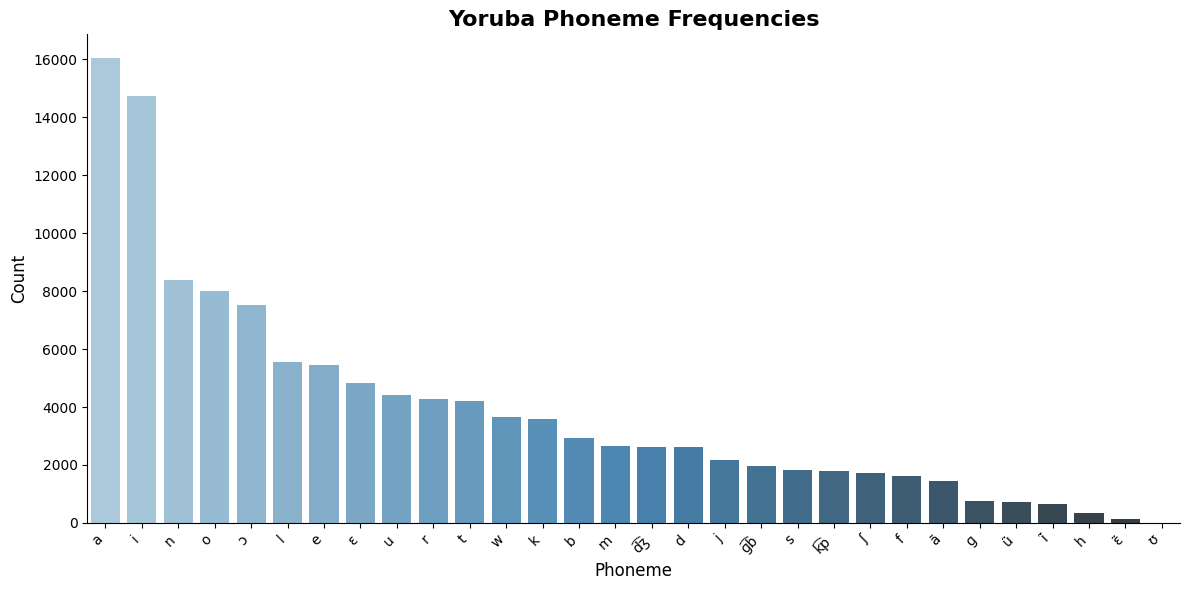

Unique phones: 30
Most common: a → 16061
Least common: ʊ → 1
Median frequency: 2645.5


In [13]:
# ai code
freqs = all_phones.value_counts()

plt.figure(figsize=(12,6))
sns.barplot(
    x=freqs.index,
    y=freqs.values,
    palette="Blues_d"
)
plt.title("Yoruba Phoneme Frequencies", fontsize=16, weight="bold")
plt.xlabel("Phoneme", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45, ha="right")
sns.despine()
plt.tight_layout()
plt.show()

print("Unique phones:", freqs.shape[0])
print("Most common:", freqs.index[0], "→", freqs.iloc[0])
print("Least common:", freqs.index[-1], "→", freqs.iloc[-1])
print("Median frequency:", freqs.median())

In [14]:
# model configuration

with open('model_config.json') as f:
  MODEL_CONFIG = json.load(f)

MODEL_CONFIG

{'ip_channel': 39,
 'num_classes': 46,
 'num_res_blocks': 3,
 'num_cnn_layers': 1,
 'cnn_filters': 50,
 'cnn_kernel_size': 15,
 'num_rnn_layers': 2,
 'rnn_dim': 128,
 'num_dense_layers': 1,
 'dense_dim': 256,
 'use_birnn': True,
 'use_resnet': True,
 'rnn_type': 'lstm',
 'rnn_dropout': 0.4}

In [15]:
def decode_ctc(logits):
    pred = torch.argmax(logits, dim=-1).cpu().numpy()
    prev = -1
    output = []
    for p in pred:
        if p != prev and p != 0:  # remove duplicates and blanks
            output.append(idx2arpa[int(p)])
        prev = p
    return " ".join(output)

In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_PATH = "ResNetCTC.pth.tar"

In [17]:
# --- Load model checkpoint ---
checkpoint_path = "checkpoint.pth"  # change to your trained model file
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ASRModel(**MODEL_CONFIG).to(device)
checkpoint = torch.load(MODEL_PATH, map_location=device)
model.load_state_dict(checkpoint["state_dict"])
model.to(device)
model.eval() # set as evaluation mode

# Yoruba idx2label
yoruba_vocab = [str(phoneme) for phoneme in unique_yor]
idx2label = {i: c for i, c in enumerate(yoruba_vocab)}

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
  warnings.warn(


In [18]:
# --- Load Yoruba dataset ---
yoruba_data = torch.load("tensor_file.pt")  # list of dicts with 'mfcc' and 'label' + 'split' information

# --- Zero-shot inference ---
test_pred = []
golden_label = []

pred_out = 'yor-predictions.txt'

with open(pred_out, mode = 'w') as f_out:
  for i, sample in enumerate(yoruba_data):
    mfcc = sample["mfcc"].to(device).unsqueeze(0).contiguous()
    with torch.no_grad():
        logits = model(mfcc)
        log_probs = F.log_softmax(logits, dim=-1)
        transcription = decode_ctc(log_probs[0])
        test_pred.append(transcription)
    f_out.write(transcription)
    f_out.write('\n')

    gt = labels[i]  # ground truth
    golden_label.append(gt)
    print(f"Sample {i}")
    print(f"   Predicted: {transcription}")
    print(f"   GroundTruth: {gt}")
print(f"Written {i + 1} predictions into {pred_out}")

Выходные данные были обрезаны до нескольких последних строк (5000).
   GroundTruth: a w ã k a n n ʃ ɔ d u n i t u n u a w ɛ w ã l ɔ d͡ʒ ɔ a i k u
Sample 1411
   Predicted: q ah v w ax ah t w ah ng ix d ah q ax y eh n q aa hv uw ax v ix q ix n ih n l ax n f ux sh eh n
   GroundTruth: ɔ k͡p ɔ l ɔ k͡p ɔ a w ã t o k u d i ɛ k a a t o l o ʃ i n b a w a ʃ i ʃ ɛ
Sample 1412
   Predicted: q a w y oh y n ah m ix n n ae w ax n q uw iy b l m y ih o l w a y n ix g iy ih n hv aa n ix n ix ng
   GroundTruth: ɔ w ɔ ɔ l ɔ k͡p a a t ɛ ɔ k u n r ĩ t o ɡ e ɔ w ɔ ɔ r ɛ b i n r ĩ r ɛ l a n a a
Sample 1413
   Predicted: iy ih ah l y ih n a n hv eh m ix ax m ax v ah l ax ix n n
   GroundTruth: i r a n j o r u b a d a r a k͡p u k͡p ɔ
Sample 1414
   Predicted: o w n ah m axr n m ix n zh ih dh iy ah n m ah n ux ax v e y ih g ix n g o w v ix d ax uw
   GroundTruth: a w ã ɔ m ɔ n a i d͡ʒ i r i a n k͡p a r i w o k͡p e i j a t o n d͡ʒ ɛ w ɔ n t i k͡p ɔ d͡ʒ u
Sample 1415
   Predicted: q ah n eh w r axr m l eh 

In [19]:
test_pred = []
with open('yor-predictions.txt', mode='r') as f_in:
  for line in f_in:
    test_pred.append(line)

test_pred = [line.replace("oh", "ao") for line in test_pred]  # crutch because of earlier bug
test_pred = [cv.arpa_to_ipa(line) for line in test_pred]

# check predicted (unique) ipas
unique_eng = set()
for pred in test_pred:
  unique_eng = unique_eng.union(set(pred.split()))

In [20]:
' '.join(sorted(unique_eng))

'a b d d͡ʒ e f h i j k l m n o p s t t͡ʃ u v w z æ ð ŋ ɑ ɔ ə ə˞ ɛ ɜ˞ ɡ ɨ ɪ ɹ ʃ ʉ ʊ ʌ ʒ ʔ θ'

In [21]:
all_pred = pd.Series(test_pred).str.split(' ').explode()

/tmp/ipython-input-3567241853.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


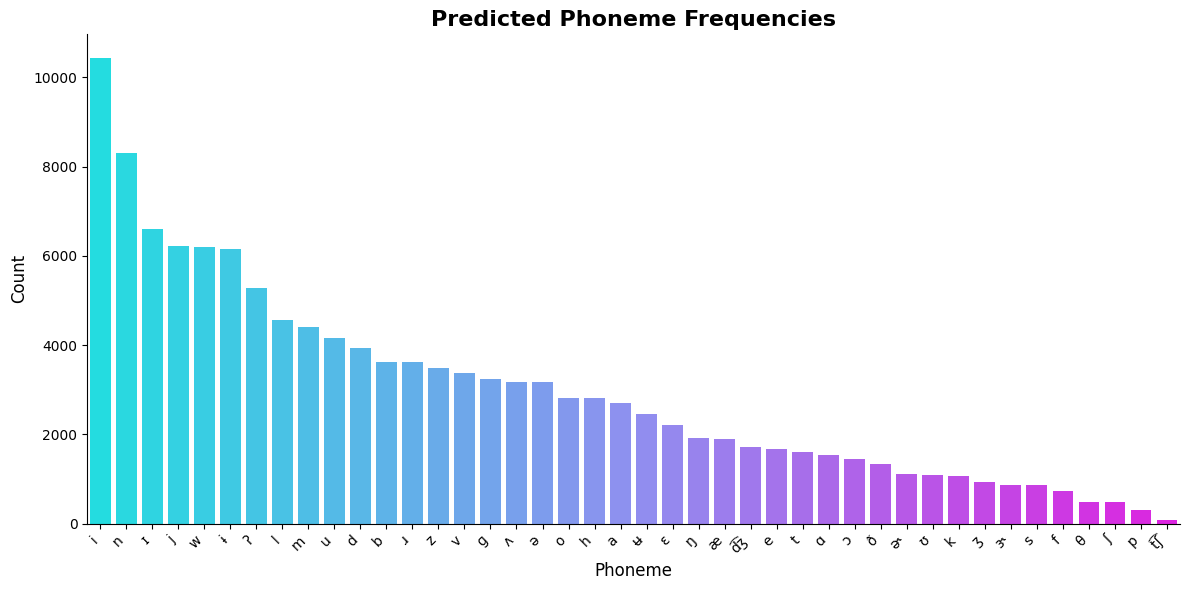

Unique phones: 42
Most common: i → 10443
Least common: t͡ʃ → 82
Median frequency: 2575.0


In [22]:
# ai code
eng_freqs = all_pred.value_counts()
turquoise = sns.color_palette("cool", n_colors=len(unique_eng))

plt.figure(figsize=(12,6))
sns.barplot(
    x=eng_freqs.index,
    y=eng_freqs.values,
    palette=turquoise
)
plt.title("Predicted Phoneme Frequencies", fontsize=16, weight="bold")
plt.xlabel("Phoneme", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45, ha="right")
sns.despine()
plt.tight_layout()
plt.show()

print("Unique phones:", eng_freqs.shape[0])
print("Most common:", eng_freqs.index[0], "→", eng_freqs.iloc[0])
print("Least common:", eng_freqs.index[-1], "→", eng_freqs.iloc[-1])
print("Median frequency:", eng_freqs.median())

In [23]:
# I observed a connection between similar sounds having similar frequencies
# That's an indirect sign of our model working correctly
# It it impossible to measure even with feature closeness and frequency closeness

In [24]:
for pred, gold in zip(test_pred[:5], golden_label[:5]):
  print(f"\nPredictions: {pred}")
  print(f"Golden labels {gold}")


Predictions: n ɪ z ɨ ŋ n h i m u m m ɪ n ɪ b ɨ h u m ɨ ɨ n h ɪ z i i e v ɨ ŋ z i ɪ m m ɛ s i ʉ m ɨ m h i n h i ɑ ɹ m u n ɨ n h u ʉ
Golden labels o t i k͡p e ɔ ɡ ɔ r u n u n ɔ d͡ʒ ɔ t i i d͡ʒ ɔ b a t i f o f ĩ d e w a

Predictions: ʔ ɹ z z ɡ u m i o w n ʔ ʊ ɡ w ə˞ i ʔ e j ɪ l k ə w ɛ n ɹ i n m k i n i b i v i ɨ j e j ɑ j ɪ i
Golden labels ɡ o m i n a o b i n r ĩ ɛ j ɔ k a n k͡p e r e l a t i n i n i i k͡p i n l ɛ a j e d e

Predictions: ʔ ʔ i n u l ʔ æ w ə z i l ɜ˞ ŋ ɹ i ɛ n d ɛ n i ɡ w b w ɨ n w w w ɑ ɹ s ɜ˞ ɹ i z i
Golden labels ĩ u a b o t i n l a n i a d͡ʒ a n i k o ɡ͡b o ɡ͡b o a w ã a ʃ ɔ r ɛ s i

Predictions: ʔ o w z i ʔ ɡ i ʔ ɪ θ ɪ h ə ɨ i t d͡ʒ i n z i ɑ m ɛ ʔ i ð ɪ ɪ j i ɹ æ d i f l ɑ t k a j m i
Golden labels k o s i i w e ɛ r i f ũ o l u d i d͡ʒ e t i a w ã ɛ ɡ͡b ɛ o n i ɡ͡b a a l ɛ f a k a l ɛ

Predictions: ʔ o w m w ɨ ɪ θ s i ð æ t a ʃ e j t ɡ ʌ m b ɨ m ɨ i m o w w ʔ d u ʌ
Golden labels a m ɔ t ɛ k u n t i ɡ͡b a a ʃ ɛ i d a a b o b o l ɔ w ɔ i d͡ʒ ɔ b a


In [25]:
eng_o = cv.EnglishInventoryOptions(split_diphthongs=True)
yor_o = cv.YorubaInventoryOptions(dialectal=True)
aligner = cv.FastAligner()
aligner.alphabets_from_project(eng_o, yor_o)
aligner.feature_maps_from_panphon()

In [26]:
aligner.set_cost_model(cv.CostModel(ndim=aligner.ndim))

In [27]:
aligner.build_tables()

In [28]:
theoretical_distances = aligner.tables.show().round(2)

In [29]:
to_drop = ["sg", "velaric", "long", "hitone", "hireg"]
aligner.feature_maps_from_panphon(drop_feats=to_drop)
costs = cv.CostModel(del_base=0.5, ins_base=0.7, normalize=True, ndim=aligner.ndim)
aligner.set_cost_model(costs)
aligner.build_tables()

In [30]:
aligner.tables.show().round(2)

Gold,a,ã,b,d,d͡ʒ,e,f,h,i,ĩ,...,ŋ,ɔ,ɛ,ɛ̃,ɡ,ɡ͡b,ɪ,ʃ,ʊ,∅
Predicted,,,,,,,,,,,,,,,,,,,,,
a,0.00,0.07,0.59,0.62,0.75,0.14,0.66,0.40,0.21,0.28,...,0.53,0.21,0.21,0.28,0.53,0.56,0.28,0.69,0.28,0.5
b,0.59,0.66,0.00,0.20,0.40,0.46,0.21,0.42,0.53,0.59,...,0.42,0.59,0.46,0.53,0.28,0.21,0.53,0.46,0.66,0.5
d,0.62,0.69,0.20,0.00,0.26,0.50,0.40,0.46,0.56,0.62,...,0.46,0.62,0.50,0.56,0.33,0.40,0.56,0.33,0.69,0.5
d͡ʒ,0.75,0.81,0.40,0.26,0.00,0.62,0.46,0.53,0.69,0.75,...,0.53,0.75,0.62,0.69,0.40,0.53,0.69,0.20,0.81,0.5
e,0.14,0.21,0.46,0.50,0.62,0.00,0.53,0.40,0.07,0.14,...,0.53,0.21,0.07,0.14,0.53,0.56,0.14,0.56,0.28,0.5
f,0.66,0.73,0.21,0.40,0.46,0.53,0.00,0.35,0.59,0.66,...,0.63,0.66,0.53,0.59,0.49,0.42,0.59,0.26,0.73,0.5
h,0.40,0.46,0.42,0.46,0.53,0.40,0.35,0.00,0.46,0.53,...,0.28,0.40,0.40,0.46,0.28,0.42,0.46,0.33,0.46,0.5
i,0.21,0.28,0.53,0.56,0.69,0.07,0.59,0.46,0.00,0.07,...,0.46,0.28,0.14,0.21,0.46,0.49,0.07,0.62,0.21,0.5
j,0.40,0.46,0.42,0.46,0.53,0.26,0.49,0.28,0.20,0.26,...,0.28,0.40,0.26,0.33,0.28,0.42,0.20,0.46,0.33,0.5


In [31]:
for pred, label in zip(test_pred[:3], golden_label[:3]):
  res = aligner.align(pred, label)
  res.show()


Distance: 19.3489
 ENG -> n ɪ z ɨ ŋ n h i m u m m ɪ n ɪ b ɨ h u m ɨ ɨ n h ɪ z i i e v ɨ ŋ z i ɪ m m ɛ s i ʉ m ɨ m h i n h i ɑ ɹ m u n ɨ n h u ʉ
 YOR -> o t i k͡p e ɔ ɡ ɔ r u n u n ɔ d͡ʒ ɔ t i i d͡ʒ ɔ b a t i f o f ĩ d e w a
n     → ∅    
ɪ     → o    
z     → t    
ɨ     → i    
ŋ     → ∅    
n     → ∅    
h     → k͡p  
i     → e    
m     → ∅    
u     → ɔ    
m     → ∅    
m     → ɡ    
ɪ     → ɔ    
n     → r    
ɪ     → ∅    
b     → ∅    
ɨ     → u    
h     → n    
u     → u    
m     → n    
ɨ     → ∅    
ɨ     → ɔ    
n     → d͡ʒ  
h     → ∅    
ɪ     → ɔ    
z     → t    
i     → i    
i     → i    
e     → ∅    
v     → ∅    
ɨ     → ∅    
ŋ     → ∅    
z     → d͡ʒ  
i     → ∅    
ɪ     → ɔ    
m     → ∅    
m     → b    
ɛ     → a    
s     → t    
i     → i    
ʉ     → ∅    
m     → f    
ɨ     → o    
m     → ∅    
h     → f    
i     → ĩ   
n     → d    
h     → ∅    
i     → e    
ɑ     → ∅    
ɹ     → ∅    
m     → ∅    
u     → w    
n     → ∅    
ɨ     → a    
n   

In [32]:
alignments = aligner.align_dataset(test_pred, golden_label)
alignments.sort_values(by='Score', ascending=True, inplace=True)

In [ ]:
alignments.head(1)

In [34]:
print("Two best predictions:")
for _, e in alignments.head(2).iterrows():
    e['All'].show()

print("\nTwo worst predictions:")
for _, e in alignments.tail(2).iloc[::-1].iterrows():
    e['All'].show()

print("\nA median prediction:")
medidx = len(alignments) // 2
alignments.loc[medidx, 'All'].show()

Two best predictions:

Distance: 6.9168
 ENG -> u i l e j d i ɑ d u l a w ə m æ d ɑ l æ l i ɹ a j ɨ z s ɔ i ɹ u b ɑ m
 YOR -> o r i l ɛ e d e a d u l a w ɔ m ɛ t a l a l o m a a n s ɔ e d e j o r u b a
u     → o    
∅     → r    
i     → i    
l     → l    
e     → ɛ    
j     → e    
d     → d    
i     → e    
ɑ     → a    
d     → d    
u     → u    
l     → l    
a     → a    
w     → w    
ə     → ɔ    
m     → m    
æ     → ɛ    
d     → t    
ɑ     → a    
l     → l    
æ     → a    
l     → l    
i     → o    
ɹ     → m    
a     → a    
j     → ∅    
ɨ     → a    
z     → n    
s     → s    
ɔ     → ɔ    
i     → e    
ɹ     → d    
u     → e    
b     → j    
ɑ     → o    
∅     → r    
∅     → u    
m     → b    
∅     → a    
PER: 0.182

Distance: 5.9649
 ENG -> o l m i ɑ j ɹ i b i ʌ l w k ʌ b ʌ d͡ʒ u l ɪ b ʊ s i i b ɔ w u
 YOR -> o m i j a l e n i ɔ l ɔ k͡p a a r ɔ d͡ʒ ɔ i b ã s i i ɡ͡b o h o
o     → o    
l     → ∅    
m     → m    
i     → i    
ɑ     → j    
j     → a 

In [51]:
correspondences = aligner.confusion_matrix(test_pred, golden_label, form="counts")
correspondences = correspondences.drop('ʊ', axis=1)  # only once in data
correspondences = correspondences.drop('ɪ', axis=1)  # never in data
correspondences = correspondences.drop('ŋ', axis=1)  # never in data
correspondences = correspondences.drop('r', axis=0)  # never in train data
correspondences = correspondences.drop('ʍ', axis=0)  # never in train data
yoruba_confusions = aligner.confusion_matrix(test_pred, golden_label, form="given_gold")
yoruba_confusions = yoruba_confusions.drop('ʊ', axis=1)  # only once in data
yoruba_confusions = yoruba_confusions.drop('ɪ', axis=1)  # never in data
yoruba_confusions = yoruba_confusions.drop('ŋ', axis=1)  # never in data
yoruba_confusions = yoruba_confusions.drop('r', axis=0)  # never in train data
yoruba_confusions = yoruba_confusions.drop('ʍ', axis=0)  # never in train data

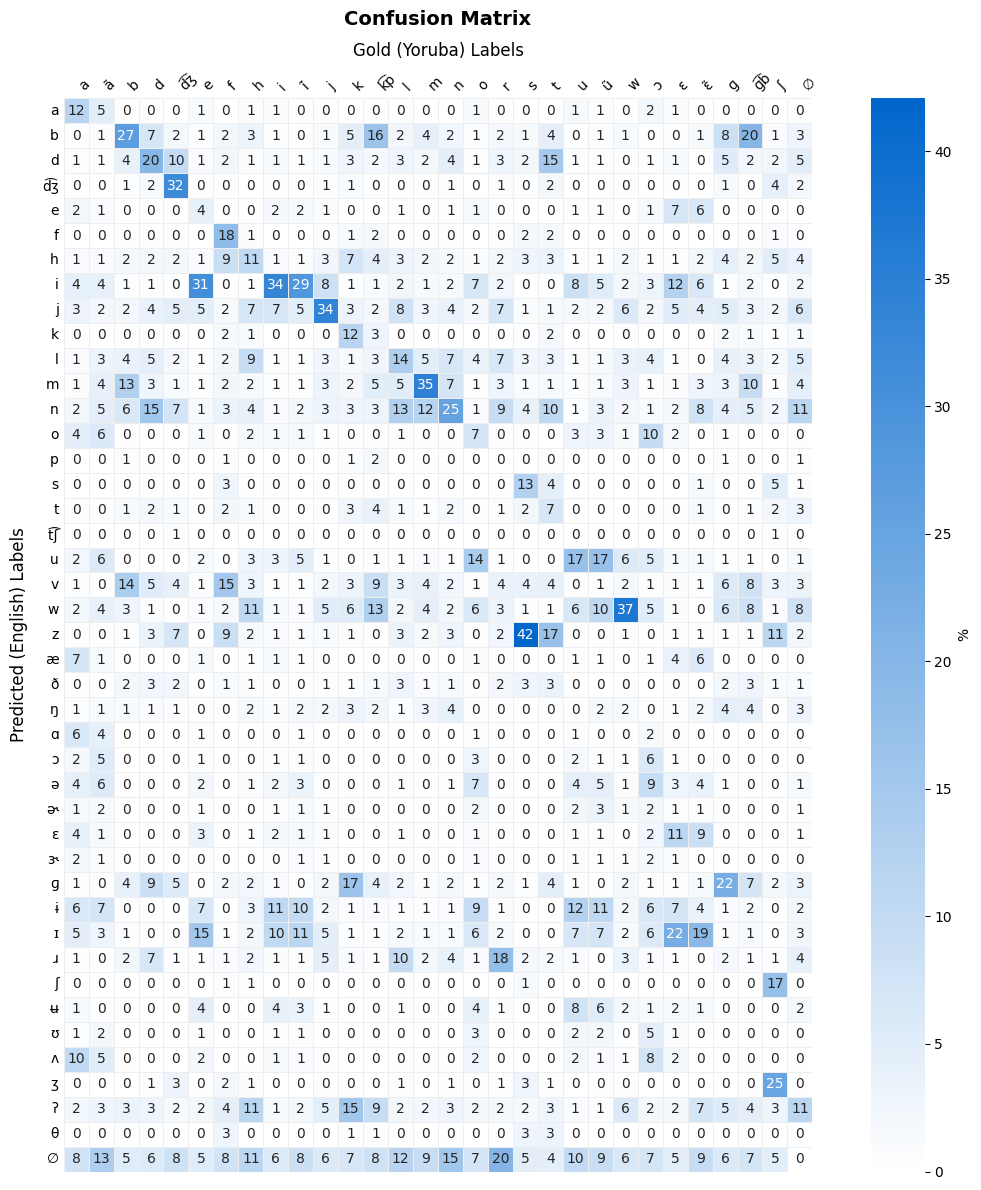

In [52]:
matrix = yoruba_confusions * 100

colors = LinearSegmentedColormap.from_list("white_to_blue", ["#ffffff", "#0066CC"])

fig, ax = plt.subplots(figsize=(12, 12))

sns.heatmap(
    matrix,
    annot=True,
    fmt=".0f",
    cmap=colors,
    square=True,
    linewidths=0.5,
    linecolor="#eeeeee",
    cbar_kws={"label": "%"},
    ax=ax
)

ax.xaxis.tick_top()
ax.xaxis.set_label_position("top")

ax.tick_params(axis='x', top=True, length=0)
ax.tick_params(axis='y', length=0)  # optional: remove from y-axis too

ax.set_xlabel("Gold (Yoruba) Labels", fontsize=12, labelpad=10)
ax.set_ylabel("Predicted (English) Labels", fontsize=12, labelpad=10)
ax.set_title("Confusion Matrix", fontsize=14, fontweight='bold', pad=12)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="left", fontsize=10)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)

plt.tight_layout()
plt.show()

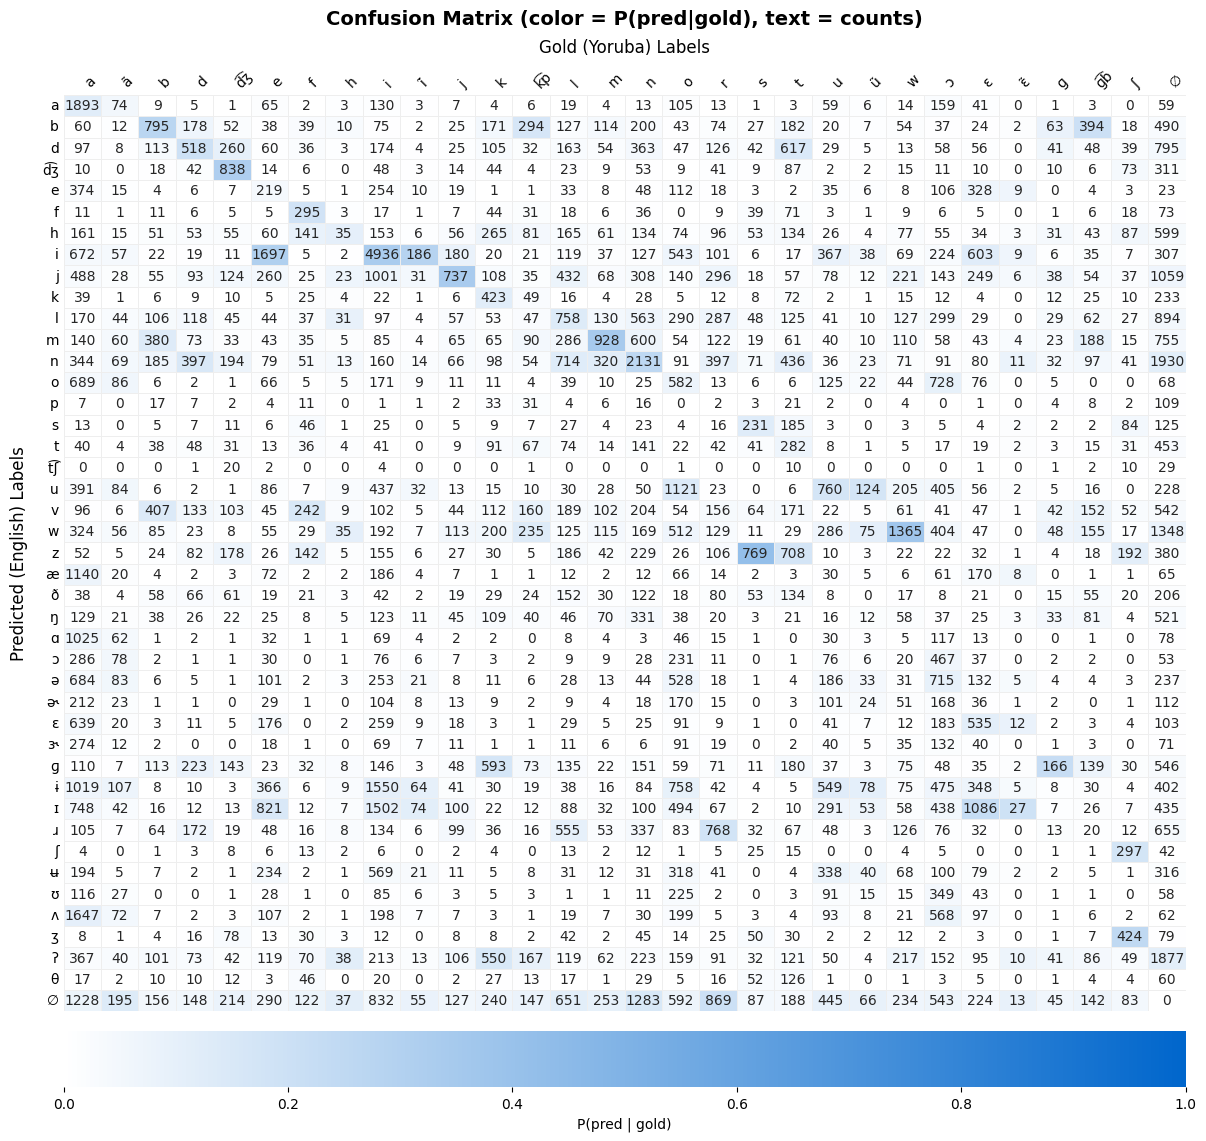

In [53]:
colors = LinearSegmentedColormap.from_list("white_to_blue", ["#ffffff", "#0066CC"])

conf = yoruba_confusions
counts = correspondences.reindex(index=conf.index, columns=conf.columns)

fig, ax = plt.subplots(figsize=(12, 12))

hm = sns.heatmap(
    conf,
    annot=counts,
    fmt="g",
    cmap=colors,
    vmin=0, vmax=1,
    square=False,                    # allow rectangular cells
    linewidths=0.5, linecolor="#eeeeee",
    cbar_kws={"label": "P(pred | gold)", "orientation": "horizontal", "pad": 0.02, "fraction": 0.06},
    ax=ax,
    annot_kws={"fontsize": 10}
)

# Make the plot area wider within the same figure size
plt.subplots_adjust(left=0.06, right=0.995, top=0.93, bottom=0.10)

ax.xaxis.tick_top()
ax.xaxis.set_label_position("top")
ax.tick_params(axis='x', top=True, length=0)
ax.tick_params(axis='y', length=0)

ax.set_xlabel("Gold (Yoruba) Labels", fontsize=12, labelpad=10)
ax.set_ylabel("Predicted (English) Labels", fontsize=12, labelpad=10)
ax.set_title("Confusion Matrix (color = P(pred|gold), text = counts)", fontsize=14, fontweight='bold', pad=10)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="left", fontsize=10)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)

plt.show()


In [54]:
print("PER (deletion costs 0.5, insertion 0.75, equiweighted features):", round(aligner.per(test_pred, golden_label), 2))

PER (deletion costs 0.5, insertion 0.75, equiweighted features): 0.33


In [55]:
# computing wPER finally
def compute_wper(corr: pd.DataFrame, cost: pd.DataFrame, E='∅') -> float:
    phones_y = corr.index
    phones_x = corr.columns

    num = 0.0
    den = 0.0
    for p in phones_y:
        for q in phones_x:
            Cpq = corr.loc[p, q]
            num += Cpq * cost.loc[p, q]
            if p != E:
                den += Cpq
    return num / den

In [56]:
print("PER (equiweighted features, deletion costs 1):", round(compute_wper(counts, theoretical_distances), 2))

PER (equiweighted features, deletion costs 1): 0.35


In [57]:
# now calculating confusion entropy, e.g. uncertainty of prediction per Yoruba sound
logprobs = np.log2(yoruba_confusions)
H_given_yor = -(yoruba_confusions * logprobs).sum(axis=0).round(2)
H_given_yor.name = 'H'
H_given_yor.sort_values(ascending=False)

/usr/local/lib/python3.12/dist-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log2
  result = func(self.values, **kwargs)


,H
∅,4.64
ã,4.55
ɔ,4.53
a,4.52
o,4.41
h,4.33
l,4.26
ũ,4.21
k͡p,4.18
ɡ,4.18


In [58]:
noempty = yoruba_confusions.drop('∅', axis=1).drop('∅', axis=0)
# noempty = noempty.T
empirical_correspondences = pd.Series([noempty[y].nlargest(4).index.values for y in noempty],
                                      index=noempty.columns, name="Top 4 confusions")
td = theoretical_distances.drop('∅', axis=1).drop('∅', axis=0)
theoretical_correspondences = pd.Series([td[y].nsmallest(4).index.values for y in td],
                                      index=td.columns, name="Top 4 closest").drop('ʊ').drop('ɪ').drop('ŋ')

In [59]:
empirical_vs_theoretical = pd.concat([empirical_correspondences, theoretical_correspondences], axis=1)  # aligns by index
empirical_vs_theoretical.columns = ["Top 4 confusions", "Top 4 closest"]
empirical_vs_theoretical['Confusion H'] = H_given_yor.drop('∅')
empirical_vs_theoretical.sort_values(by='Confusion H', ascending=True)

,Top 4 confusions,Top 4 closest,Confusion H
s,"[z, s, n, v]","[s, z, t, ʃ]",3.40
m,"[m, n, l, w]","[m, b, n, p]",3.67
d͡ʒ,"[d͡ʒ, d, n, z]","[d͡ʒ, t͡ʃ, ʒ, ʃ]",3.69
b,"[b, v, m, n]","[b, p, m, v]",3.76
ʃ,"[ʒ, ʃ, z, h]","[ʃ, ʒ, s, t͡ʃ]",3.80
i,"[i, ɨ, ɪ, j]","[i, e, ɨ, ɪ]",3.81
w,"[w, j, ʔ, u]","[w, ʍ, u, ə˞]",3.82
e,"[i, ɪ, ɨ, j]","[e, i, æ, ɛ]",3.87
j,"[j, i, w, ʔ]","[j, i, ɪ, w]",3.92
ĩ,"[i, ɪ, ɨ, u]","[i, e, ɨ, ɪ]",3.93


In [44]:
# Prediction entropy: how certainly do we know the original from the predicted?

In [61]:
timit_confusions = aligner.confusion_matrix(test_pred, golden_label, form="given_gold")

In [62]:
timit_confusions = timit_confusions.drop('ʊ', axis=1).drop('ɪ', axis=1).drop('ŋ',
                            axis=1).drop('r', axis=0).drop('ʍ', axis=0)

In [63]:
# now calculating confusion entropy, e.g. uncertainty of prediction per Yoruba sound
logprobs = np.log2(timit_confusions)
H_given_pred = -(timit_confusions * logprobs).sum(axis=1).round(2)
H_given_pred.name = 'H'
H_given_pred.sort_values(ascending=False)

/usr/local/lib/python3.12/dist-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log2
  result = func(self.values, **kwargs)


,H
∅,8.30
n,6.18
j,5.40
w,5.28
ʔ,5.14
i,5.02
ɪ,4.79
l,4.45
v,4.40
m,4.36


Conclusion: a number of sounds are really unamiguously correspondent. A number of frequent sounds are not: front high vowels align to many vowels, highly sonorant and labial consonants are likely predicted instead of many sounds.

In [67]:
noempty = timit_confusions.drop('∅', axis=1).drop('∅', axis=0).T
empirical_correspondences = pd.Series([noempty[y].nlargest(4).index.values for y in noempty],
                                      index=noempty.columns, name="Top 4 confusions")
td = theoretical_distances.drop('∅', axis=1).drop('∅', axis=0).T
theoretical_correspondences = pd.Series([td[y].nsmallest(4).index.values for y in td],
                                      index=td.columns, name="Top 4 closest").drop('r').drop('ʍ')

In [68]:
empirical_vs_theoretical = pd.concat([empirical_correspondences, theoretical_correspondences], axis=1)  # aligns by index
empirical_vs_theoretical.columns = ["Top 4 correspondences", "Top 4 closest"]
empirical_vs_theoretical['Prediction H'] = H_given_pred.drop('∅')
empirical_vs_theoretical.sort_values(by='Prediction H', ascending=True)

,Top 4 correspondences,Top 4 closest,Prediction H
t͡ʃ,"[d͡ʒ, ʃ, t, ɡ]","[d͡ʒ, ʃ, s, t]",0.18
p,"[k͡p, k, f, b]","[b, f, t, k͡p]",0.58
ʃ,"[ʃ, s, f, h]","[ʃ, s, d͡ʒ, f]",0.84
θ,"[t, f, s, k]","[s, t, ʃ, d]",0.89
ɜ˞,"[ɔ, a, o, ĩ]","[ʊ, ɔ, o, u]",0.91
ɑ,"[a, ã, ɔ, u]","[a, ã, e, o]",1.00
ʊ,"[ɔ, o, ũ, u]","[ʊ, ɔ, o, u]",1.11
ə˞,"[ũ, u, ɔ, o]","[ʊ, ɔ, o, u]",1.32
f,"[f, s, k͡p, t]","[f, s, b, ʃ]",1.35
ɔ,"[ɔ, ã, o, a]","[ɔ, o, ʊ, ɛ]",1.36


A closer look reveals that even the sounds that have unambiguous correspondences are often correspondent to the phonologically closest sounds the most. This was not characteristic of confusion entropy

In [49]:
# Probabilities, given the error inherent in the model -> to ilinca

In [123]:
# PMI
joint_probs = aligner.confusion_matrix(test_pred, golden_label, form="joint")
joint_probs = joint_probs.drop('ʊ', axis=1).drop('ɪ', axis=1).drop('ŋ',
                  axis=1).drop('r', axis=0).drop('ʍ', axis=0)
J = joint_probs.to_numpy()

In [126]:
gold_sound_probs = np.broadcast_to(J.sum(axis=1)[:, None], J.shape)
pred_sound_probs = np.broadcast_to(J.sum(axis=0), J.shape)

logjoint = np.full_like(J, -np.inf)
np.log2(J, out=logjoint, where=(J > 0))

logpgold = np.full_like(gold_sound_probs, -np.inf)
np.log2(gold_sound_probs, out=logpgold, where=(gold_sound_probs > 0))

logppred = np.full_like(pred_sound_probs, -np.inf)
np.log2(pred_sound_probs, out=logppred, where=(pred_sound_probs > 0))

PMI = logjoint - logppred - logpgold

In [138]:
infinities_mask = (J > 0)
NPMI = np.full_like(PMI, np.nan)  # set inf to None
NPMI[infinities_mask] = PMI[infinities_mask] / (-logjoint[infinities_mask])

In [139]:
NPMI = pd.DataFrame(NPMI, index=joint_probs.index, columns=joint_probs.columns).round(2)

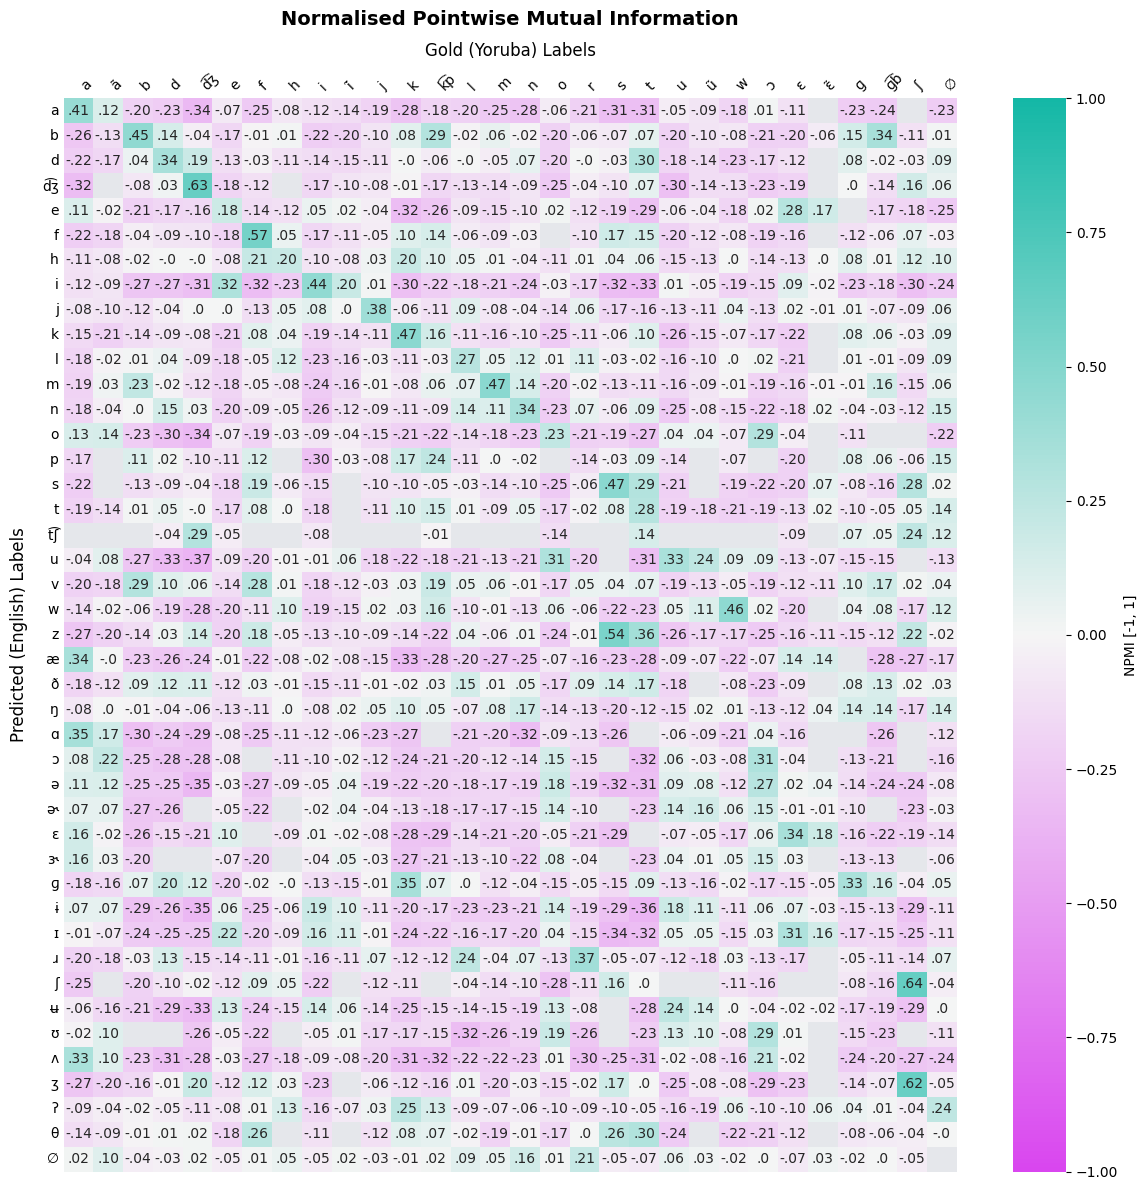

In [140]:
matrix = NPMI

cmap = LinearSegmentedColormap.from_list(
    "magenta_gray_turquoise",
    ["#d946ef", "#f5f5f5", "#14b8a6"]
)
cmap.set_bad("#e5e7eb")

norm = TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)

fig, ax = plt.subplots(figsize=(12, 12))

hm = sns.heatmap(
    matrix,
    annot=True,
    fmt=".2f",
    cmap=cmap,
    norm=norm,
    cbar_kws={"label": "NPMI [-1, 1]"},
    ax=ax,
)

for t in hm.texts:
    s = t.get_text()
    s = s.replace("-0.", "-.").replace("0.", ".").replace(".00", ".0")
    t.set_text(s)

ax.xaxis.tick_top()
ax.xaxis.set_label_position("top")
ax.tick_params(axis='x', top=True, length=0)
ax.tick_params(axis='y', length=0)

ax.set_xlabel("Gold (Yoruba) Labels", fontsize=12, labelpad=10)
ax.set_ylabel("Predicted (English) Labels", fontsize=12, labelpad=10)
ax.set_title("Normalised Pointwise Mutual Information", fontsize=14, fontweight='bold', pad=12)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="left", fontsize=10)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)

plt.tight_layout()
plt.show()


In [ ]:
# Benchmarking PER: what is the PER of randomly generated sequences unrelated to the audio?

In [ ]:
seed = 119

In [ ]:
print("Model generated")
print("Mean PER per sentence:", round(alignments['Score'].mean(), 2))
print("Std:", round(alignments['Score'].std(), 2))

Model generated
Mean PER per sentence: 0.34
Std: 0.06


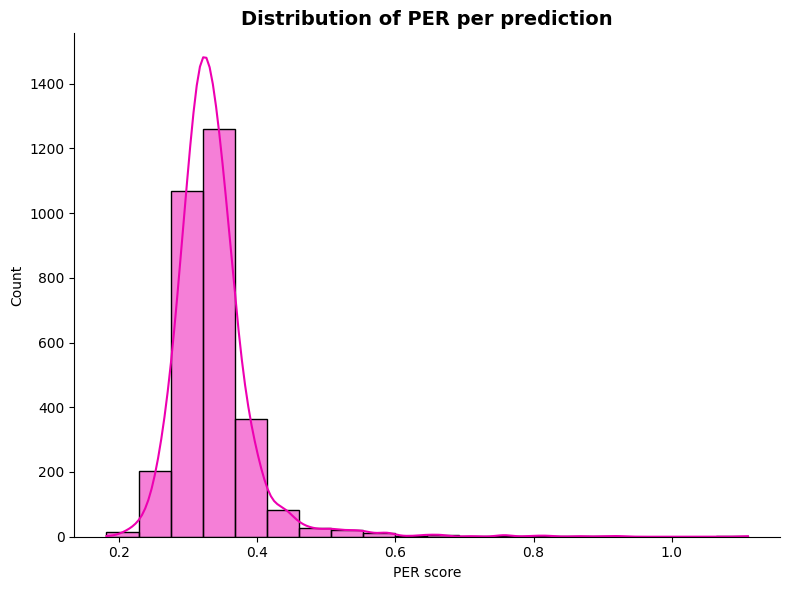

In [ ]:
plt.figure(figsize=(8,6))
ax = sns.histplot(alignments['Score'], bins=20, kde=True, color="#ED00B1")
plt.title("Distribution of PER per prediction", fontsize=14, weight="bold")
plt.xlabel("PER score")
plt.ylabel("Count")
sns.despine()
plt.tight_layout()
plt.show()
for_comparison = ax.get_xlim()

In [ ]:
# equal probability modelling, same lengths as predictions

import random
random.seed(seed)

L = list(unique_eng)
lengths = pd.Series(test_pred).str.split().str.len()

one_gen = lengths.apply(lambda x: random.choices(L, k=x))
one_gen = one_gen.str.join(' ').to_list()

In [ ]:
rand_alignments = aligner.align_dataset(one_gen, golden_label)
rand_alignments.sort_values(by='Score', ascending=True, inplace=True)
print("Equal probabilities generated")
print("Mean PER per sentence:", round(rand_alignments['Score'].mean(), 2))
print("Std:", round(rand_alignments['Score'].std(), 2))

Equal probabilities generated
Mean PER per sentence: 0.36
Std: 0.03


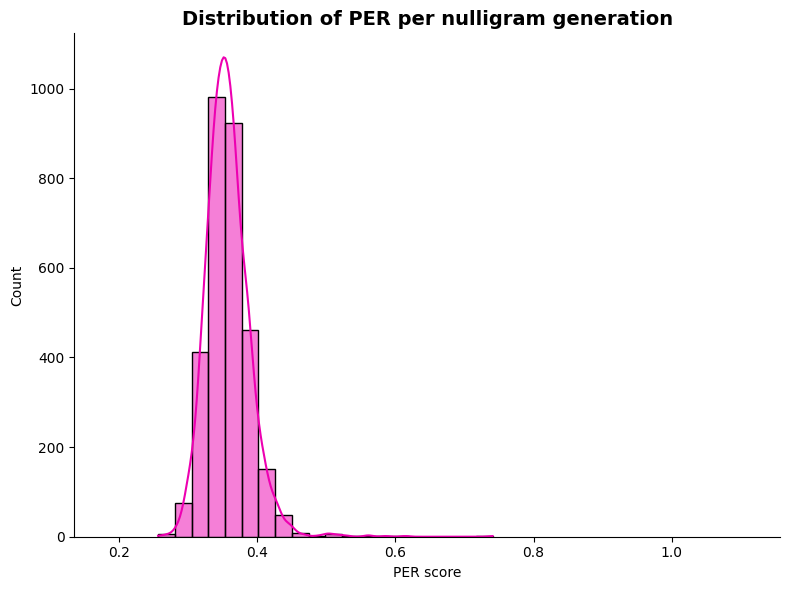

In [ ]:
plt.figure(figsize=(8,6))
ax2 = sns.histplot(rand_alignments['Score'], bins=20, kde=True, color="#ED00B1")
ax2.set_xlim(for_comparison)
plt.title("Distribution of PER per nulligram generation", fontsize=14, weight="bold")
plt.xlabel("PER score")
plt.ylabel("Count")
sns.despine()
plt.tight_layout()
plt.show()

In [ ]:
# unigram probability, same lengths as predictions
weights = eng_freqs.reindex(L).values.tolist()  # probs of letters

Unigram probabilities generated
Mean PER per sentence: 0.35
Std: 0.03


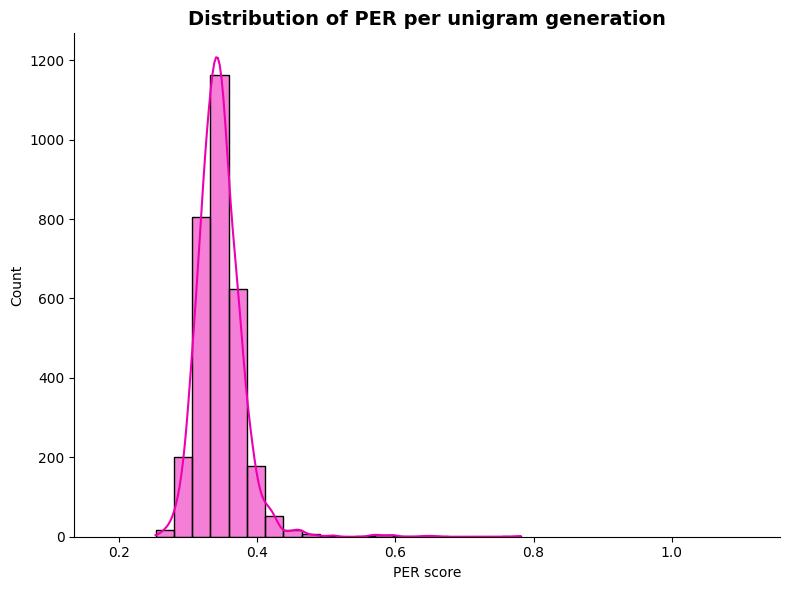

In [ ]:
one_gen = lengths.apply(lambda x: random.choices(L, k=x, weights=weights))
one_gen = one_gen.str.join(' ').to_list()
rand_alignments = aligner.align_dataset(one_gen, golden_label)
rand_alignments.sort_values(by='Score', ascending=True, inplace=True)
print("Unigram probabilities generated")
print("Mean PER per sentence:", round(rand_alignments['Score'].mean(), 2))
print("Std:", round(rand_alignments['Score'].std(), 2))

plt.figure(figsize=(8,6))
ax2 = sns.histplot(rand_alignments['Score'], bins=20, kde=True, color="#ED00B1")
ax2.set_xlim(for_comparison)
plt.title("Distribution of PER per unigram generation", fontsize=14, weight="bold")
plt.xlabel("PER score")
plt.ylabel("Count")
sns.despine()
plt.tight_layout()
plt.show()

In [ ]:
# bigram probability, rndom lengthsf
import nltk
from nltk import bigrams, ConditionalFreqDist

corpus = ['/']
for se in test_pred:
    for ph in se.split():
        corpus.append(ph)
    corpus.append('/')

cfd = ConditionalFreqDist(bigrams(corpus))

In [ ]:
def next_phone(ph):
    dist = cfd[ph]
    return random.choices(list(dist.keys()), weights=dist.values(), k=1)[0]
def gen_pred():
    before ='/'
    for _ in range(60):
        after = next_phone(before)
        if after == '/':
            return
        yield after
        before = after

Bigram probabilities generated
Mean PER per sentence: 0.45
Std: 0.14


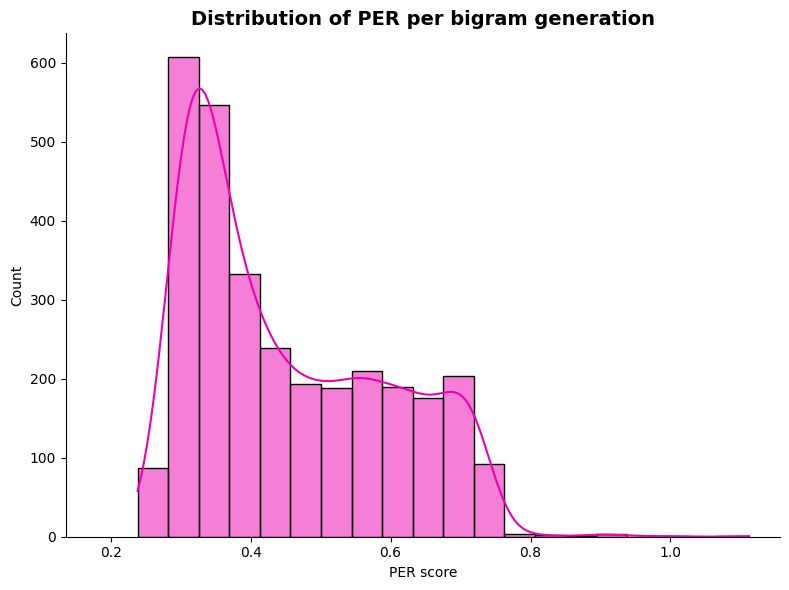

In [ ]:
one_gen = lengths.apply(lambda x: ' '.join(gen_pred())).to_list()
rand_alignments = aligner.align_dataset(one_gen, golden_label)
rand_alignments.sort_values(by='Score', ascending=True, inplace=True)
print("Bigram probabilities generated")
print("Mean PER per sentence:", round(rand_alignments['Score'].mean(), 2))
print("Std:", round(rand_alignments['Score'].std(), 2))

plt.figure(figsize=(8,6))
ax2 = sns.histplot(rand_alignments['Score'], bins=20, kde=True, color="#ED00B1")
ax2.set_xlim(for_comparison)
plt.title("Distribution of PER per bigram generation", fontsize=14, weight="bold")
plt.xlabel("PER score")
plt.ylabel("Count")
sns.despine()
plt.tight_layout()
plt.show()

###Not for our project: experiments with weights for features


0. sg[9], velaric[19], long[21], hitone[22], hireg[23] are deleted

after that:
1. +cg[9] gives a giant discount to delete
2. changing +syl[0] is punished
3. substituting nas[6], deleting nas is encouraged
4. deleting +cons[2] is encouraged, inserting +syl is encouraged

In [ ]:
cm = cv.CostModel(ndim=aligner.ndim)
cm.sub_weights[0] = 5
cm.sub_weights[6] = 0.2
cm.del_mult[6] = 0.7
cm.del_mult[9] = 0.1
cm.del_mult[2] = 0.5
cm.del_mult[11] = 0.4
cm.del_base = 0.5
cm.ins_base = 0.75
cm.ins_mult[0] = 1.25
cm.normalize = True

In [ ]:
newa = aligner.set_cost_model(cm)
newa.build_tables()
newa.tables.show().round(2).head()

Gold,a,ã,b,d,d͡ʒ,e,f,h,i,ĩ,...,ŋ,ɔ,ɛ,ɛ̃,ɡ,ɡ͡b,ɪ,ʃ,ʊ,∅
Predicted,,,,,,,,,,,,,,,,,,,,,
a,0.00,0.01,0.71,0.73,0.83,0.11,0.76,0.55,0.17,0.18,...,0.61,0.17,0.17,0.18,0.65,0.69,0.23,0.78,0.23,0.50
b,0.71,0.72,0.00,0.16,0.33,0.60,0.17,0.34,0.65,0.67,...,0.30,0.71,0.60,0.61,0.23,0.17,0.65,0.38,0.76,0.25
d,0.73,0.74,0.16,0.00,0.22,0.62,0.33,0.38,0.68,0.69,...,0.34,0.73,0.62,0.64,0.27,0.33,0.68,0.27,0.78,0.20
d͡ʒ,0.83,0.84,0.33,0.22,0.00,0.73,0.38,0.44,0.78,0.79,...,0.39,0.83,0.73,0.74,0.33,0.44,0.78,0.16,0.89,0.20
e,0.11,0.13,0.60,0.62,0.73,0.00,0.65,0.55,0.06,0.07,...,0.61,0.17,0.06,0.07,0.65,0.69,0.11,0.68,0.23,0.50


In [ ]:
for pred, gold in zip(test_pred[:3], golden_label[:3]):
    res = newa.align(pred, gold)
    res.show()


Distance: 13.4896
 ENG -> n ɪ z ɨ ŋ n h i m u m m ɪ n ɪ b ɨ h u m ɨ ɨ n h ɪ z i i e v ɨ ŋ z i ɪ m m ɛ s i ʉ m ɨ m h i n h i ɑ ɹ m u n ɨ n h u ʉ
 YOR -> o t i k͡p e ɔ ɡ ɔ r u n u n ɔ d͡ʒ ɔ t i i d͡ʒ ɔ b a t i f o f ĩ d e w a
n     → ∅    
ɪ     → o    
z     → t    
ɨ     → i    
ŋ     → k͡p  
n     → ∅    
h     → ∅    
i     → e    
m     → ∅    
u     → ɔ    
m     → ∅    
m     → ɡ    
ɪ     → ɔ    
n     → r    
ɪ     → ∅    
b     → ∅    
ɨ     → u    
h     → n    
u     → u    
m     → n    
ɨ     → ∅    
ɨ     → ɔ    
n     → d͡ʒ  
h     → ∅    
ɪ     → ɔ    
z     → t    
i     → i    
i     → i    
e     → ∅    
v     → ∅    
ɨ     → ∅    
ŋ     → ∅    
z     → d͡ʒ  
i     → ∅    
ɪ     → ɔ    
m     → ∅    
m     → b    
ɛ     → a    
s     → t    
i     → i    
ʉ     → ∅    
m     → f    
ɨ     → o    
m     → f    
h     → ∅    
i     → ĩ   
n     → d    
h     → ∅    
i     → e    
ɑ     → ∅    
ɹ     → ∅    
m     → ∅    
u     → w    
n     → ∅    
ɨ     → a    
n   